# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [79]:
import numpy as np
from datetime import datetime
import os
import time
from IPython.display import FileLink, display 
import matplotlib.pyplot as plt
%matplotlib notebook

import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import skbeam.core.utils as utils

from chxanalys.chx_libs import getpass, db
from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, load_data, load_mask,
                                             apply_mask, get_each_frame_intensity, create_hot_pixel_mask)
from chxanalys.XPCS_SAXS import get_circular_average, get_ring_mask
from chxanalys.Two_Time_Correlation_Function import (Get_Pixel_Array, auto_two_Array,show_C12,
                                                     get_one_time_from_two_time)

In [133]:
CYCLE = '2016_2'

In [22]:
uid = 'b5feeb' #Measurement: Silica 10k fr x .002 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08 
               #Note: we used this data for Sameera's paper

In [23]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1846--b5feeb96-cdb0-455f-b078-1b6052326c27--/XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192


In [25]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192_master.h5


In [26]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [27]:
md

{'beam_center_x': 1232.0,
 'beam_center_y': 903.0,
 'count_time': 0.00199,
 'detector_distance': 4.8400002,
 'frame_time': 0.0020000001,
 'framerate': 499.99997625127548,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [28]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime = md['count_time']
acquisition_period = md['frame_time']

timeperframe = exposuretime

#center = [  1338, 2167 - 424  ]  # center of the speckle pattern

center = [   1227,1261  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print (center)

[1261, 1227]


In [29]:
setup_pargs = dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)
setup_pargs

{'Ldet': 4840.0,
 'center': [1261, 1227],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.00199,
 'uid': 'b5feeb'}

##  Get the mask and find the bad frames

<IPython.core.display.Javascript object>


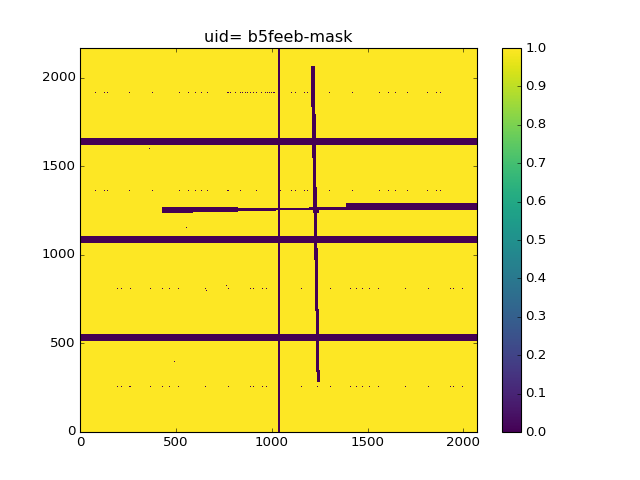

100%|██████████| 10000/10000 [16:48<00:00, 10.48it/s]


<IPython.core.display.Javascript object>


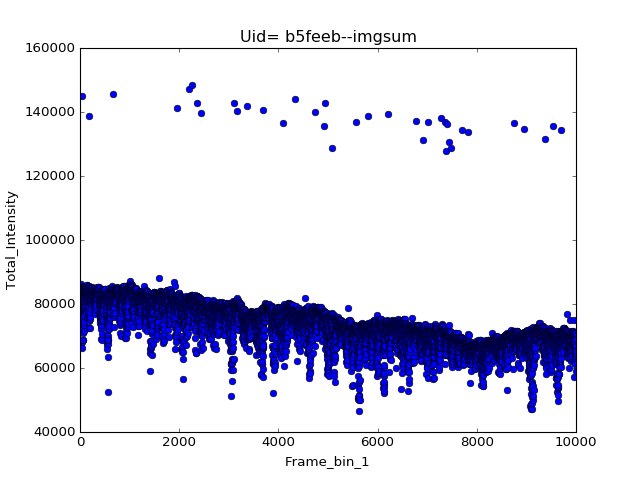

No bad frames are involved.


In [35]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'fcdba400-4b7e_mask.npy'
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )
imgsa = apply_mask(imgs, mask)
good_series = apply_mask(imgsa[0:], mask)
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 1, 
                                bad_pixel_threshold=1.2e8,  plot_ = True, uid=uid)

<IPython.core.display.Javascript object>


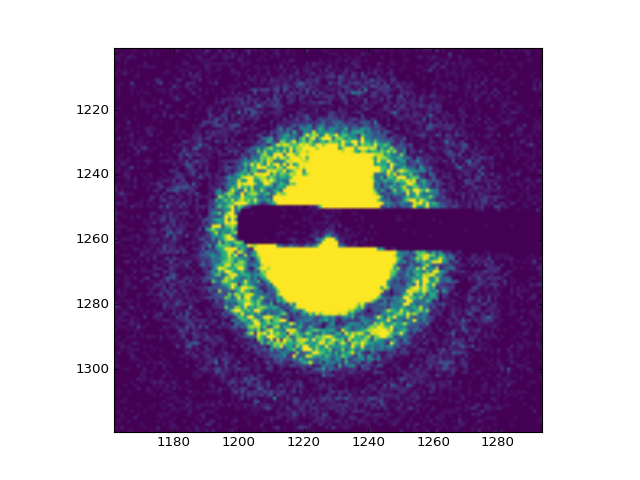

In [52]:
plt.figure()
plt.imshow(imgs[0], vmin=0.1, vmax=20, cmap="viridis")
plt.show()

## Get the radial integration(circular average)

In [36]:
avg_img = np.average(imgs[::100], axis=0)*mask

<IPython.core.display.Javascript object>


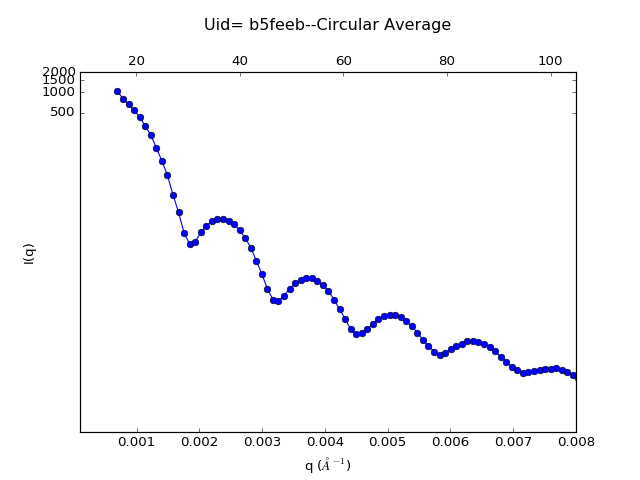

In [41]:
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask*hmask, pargs=setup_pargs, 
                    plot_ = True, plot_qinpixel=False, xlim=[0.0001,.008], ylim = [0.01, 2000])

## Create the "labels" or Ring mask for the analysis

In [47]:
inner_radius= 15
outer_radius = 105
width = 6
num_rings = 14

ring_mask, q_ring_center, q_ring_val = get_ring_mask(mask=mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs)

<IPython.core.display.Javascript object>


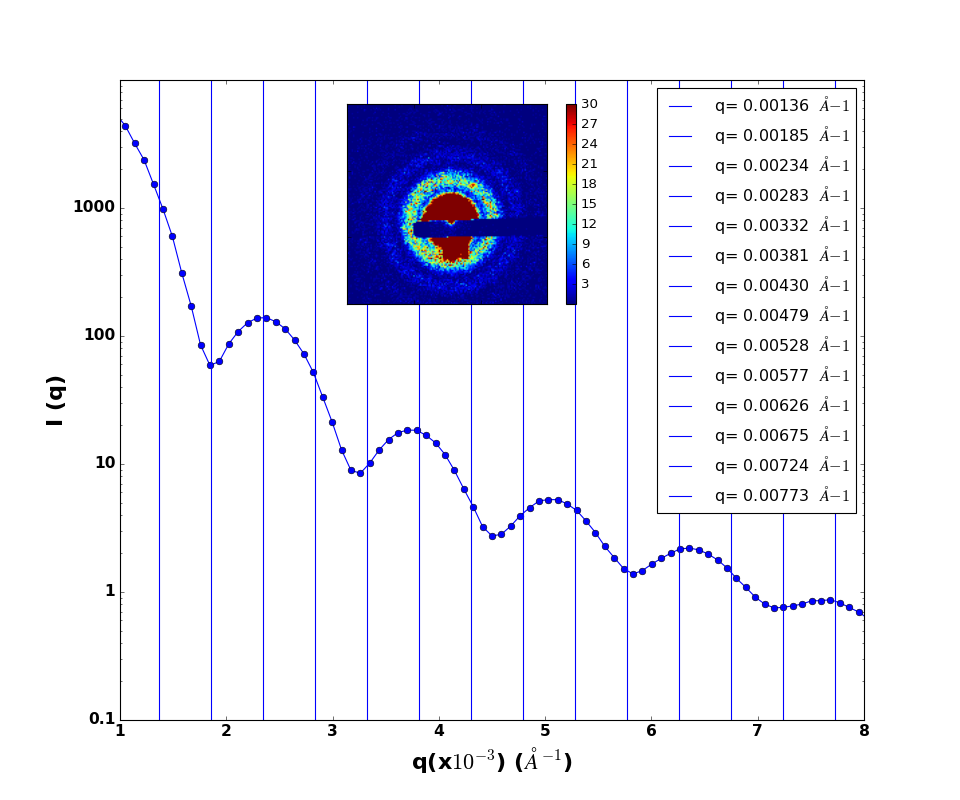

  adjustable: [ 'box' | 'datalim' | 'box-forced'] 
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  anchor: unknown
  animated: [True | False] 
  aspect: unknown
  autoscale_on: unknown
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes: an :class:`~matplotlib.axes.Axes` instance 
  axes_locator: unknown
  axis_bgcolor: any matplotlib color - see :func:`~matplotlib.pyplot.colors` 
  axisbelow: [ *True* | *False* ] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color_cycle: unknown
  contains: a callable function 
  figure: unknown
  frame_on: [ *True* | *False* ] 
  gid: an id string 
  label: string or anything printable with '%s' conversion. 
  navigate: [ *True* | *False* ] 
  navigate_mode: unknown
  path_effects: unknown
  picker: [None|float|boolean|callable] 
  positi

In [93]:
axis_font = {'fontname':'Arial', 'size':'20', 'fontweight':'bold'}
axis_font2 = {'fontname':'Arial', 'size':'14', 'fontweight':'bold'}
fig, axes = plt.subplots(figsize=(12, 10))
axes.semilogy(q, iq, '-o')
axes.set_ylabel('I (q)', **axis_font)
axes.set_xlabel('q(x$10^{-3}$) ('r'$\AA^{-1}$)', **axis_font)
axes.set_xlim(0.001, 0.008)
axes.set_ylim(0.01, 1000)
for i in range(num_rings):
    axes.axvline(q_ring_center[i], label=" q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA{-1}$')
axes.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8], **axis_font2)
axes.set_yticklabels([10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2), 10**(3)], **axis_font2)
ax = plt.axes([.25, .62, .4, .25], axisbg='y')
im = ax.imshow(imgs[0], vmin=0.01, vmax=30, cmap="jet")
rwidth = 15
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
ax.set_xlim( [x1,x2])
ax.set_ylim( [y1,y2])
ax.set_xticks([1150, 1200, 1250, 1300])
ax.set_xticklabels([])
ax.set_yticks([1200, 1250, 1300, 1350])
ax.set_yticklabels([])
axes.legend(loc=1)
plt.colorbar(im)
plt.setp(ax)
plt.show()

##  One-time multi tau corrleation 

In [74]:
num_lev =12
num_buf= 8

t0 = time.time()
g2, lag_steps  = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, imgs)
t1 = time.time() - t0
t1

In [76]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

<IPython.core.display.Javascript object>


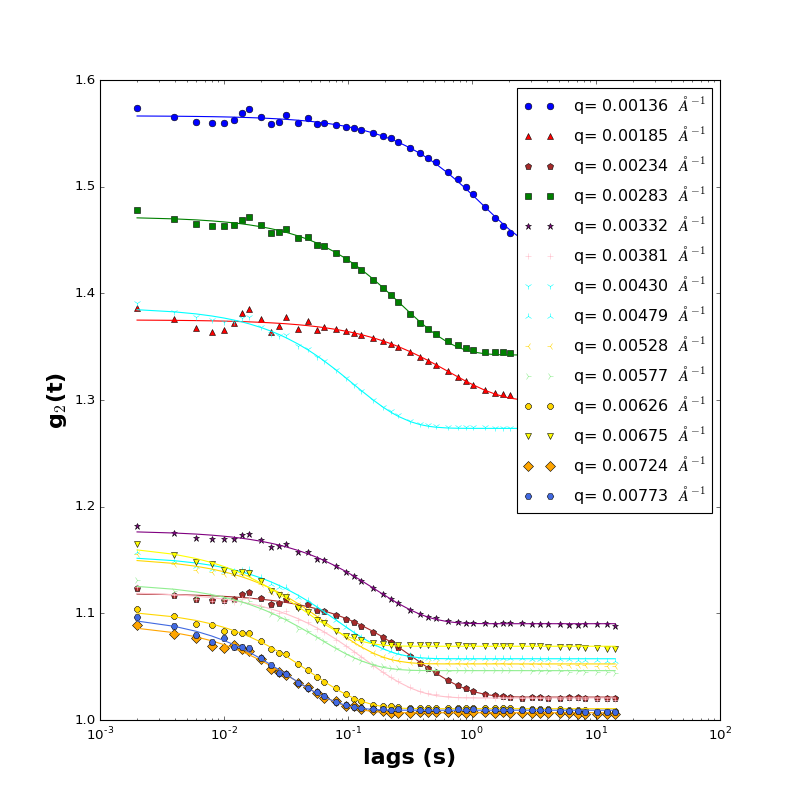

In [77]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)

rate3 = []
fig, axes = plt.subplots(1, figsize=(10, 10))
roi_names = ["blue", "red", "brown", "green", "purple", "pink", "cyan", "aqua", "gold",
             "lightgreen", "gold", "yellow", "orange", "royalblue"]
marks = ["o", "^", "p", "s", "*","+", "1", "2", "3", "4", "8", "v", "D",  "H"]
for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    
    y = g2[1:, i]
    result3 = mod.fit(y, lags=lag_steps[1:], beta=.1,
                     relaxation_rate =.01, baseline=1.0)
    rate3.append(result3.best_values['relaxation_rate'])
    axes.semilogx(taus[1:], g2[1:, i], mark, markerfacecolor=roi_color, color=roi_color,
                  markersize=6, label=" q = " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes.semilogx(taus[1:], result3.best_fit, '-', c=roi_color)
axes.set_ylabel("g$_{2}$(t)", **axis_font)
axes.set_xlabel("lags (s)", **axis_font)
axes.legend(loc=1)
plt.show()

<IPython.core.display.Javascript object>


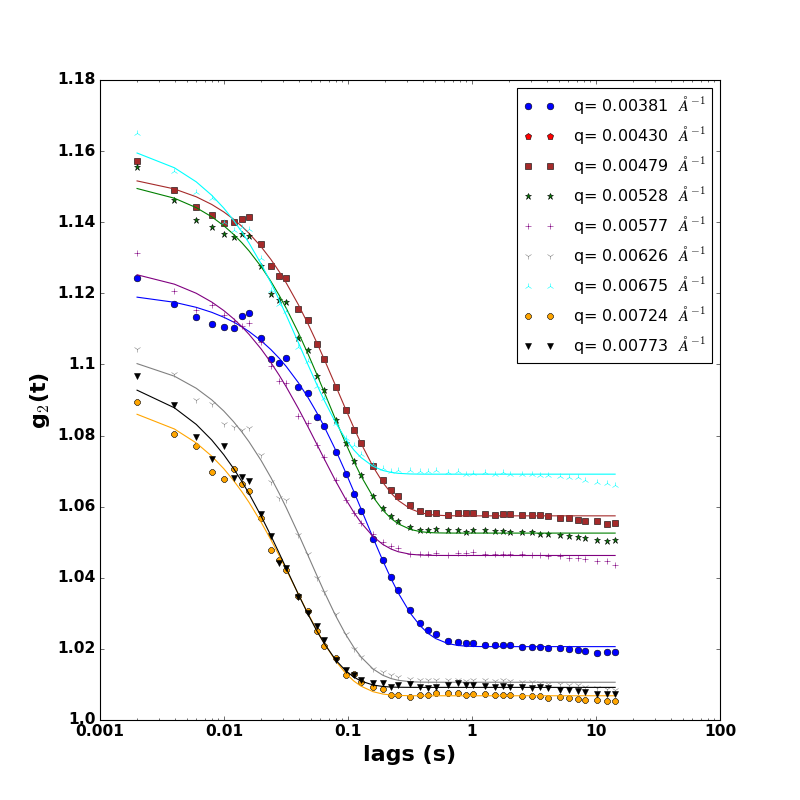

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [132]:
rate33 = []
fig, axes = plt.subplots(1, figsize=(10, 10))
roi_names = ["blue", "red", "brown", "green", "purple", "gray", "cyan", "orange", "black",
              "aqua"]

marks = ["o", "p", "s", "*","+", "1", "2","8", "v", "D",  "H"]
for i, roi_color, mark in zip(range(5, num_rings), roi_names, marks):
    
    y = g2[1:, i]
    result33 = mod.fit(y, lags=lag_steps[1:], beta=.1,
                     relaxation_rate =.01, baseline=1.0)
    rate33.append(result33.best_values['relaxation_rate'])
    axes.semilogx(taus[1:], g2[1:, i], mark, markerfacecolor=roi_color, color=roi_color, markersize=6,
                 label=" q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes.semilogx(taus[1:], result33.best_fit, '-', c=roi_color)
                 #label=" q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
axes.set_ylim(bottom=1, top=1.18)
axes.set_ylabel("g$_{2}$(t)", **axis_font)
axes.set_xlabel("lags (s)", **axis_font)
axes.set_yticklabels([1.00, 1.02, 1.04, 1.06, 1.08, 1.10, 1.12, 1.14, 1.16, 1.18], **axis_font2)
axes.set_xticklabels([0, 10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2)], **axis_font2)
fig.savefig("g2.svg", bbox_inches='tight')
axes.legend(loc=1)
plt.show()

## Two time correlation 

In [ ]:
qind, pixelist = roi.extract_label_indices(  ring_mask  )
t0 = time.time()
data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
g12b = auto_two_Array(good_series, ring_mask, data_pixel = data_pixel)

 11%|█         | 1061/10000 [00:56<07:53, 18.87it/s]

## Get the one-time corrleation results using two-time corrleation

In [97]:
g21 = get_one_time_from_two_time(g12b)
taus2 = np.arange(g21.shape[0])* timeperframe

In [107]:
taus21 = np.arange(g12b.shape[0])* 0.002

<IPython.core.display.Javascript object>


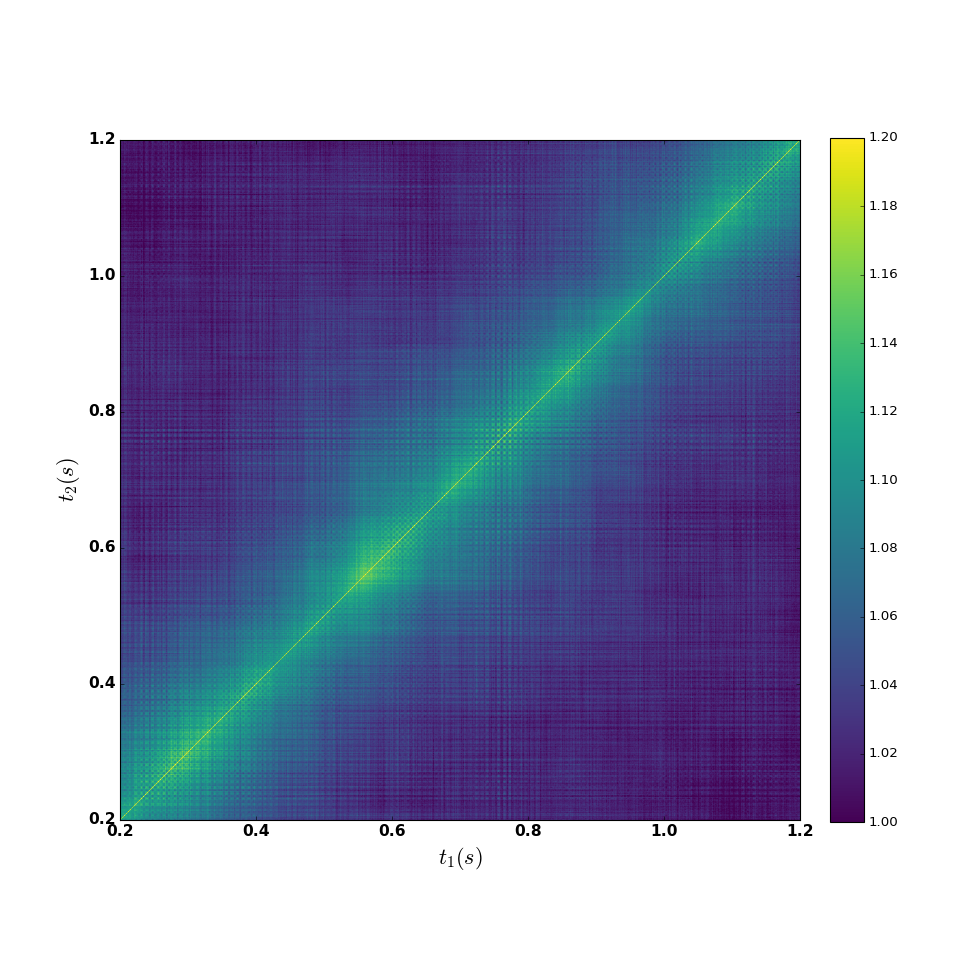

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [131]:
fig, ax1 = plt.subplots(figsize=(12, 12))
im = plt.imshow(g12b[0:1000, 0:1000, 2], vmin=1, vmax=1.2, origin="low", cmap="viridis")
ax1.set_xticklabels([taus21[0], taus21[100] , taus21[200], taus21[300], taus21[400],
                    taus21[500],taus21[600], taus21[700], taus21[800], taus21[900], taus21[1000] ], **axis_font2)
ax1.set_yticklabels([taus21[0], taus21[100], taus21[200], taus21[300], taus21[400],
                    taus21[500],taus21[600], taus21[700], taus21[800], taus21[900], taus21[1000]], **axis_font2)
plt.colorbar(im,fraction=0.046, pad=0.04)
ax1.set_xlabel("$t_{1} (s)}$", **axis_font)
ax1.set_ylabel("$t_{2} (s)$", **axis_font)
fig.savefig("C_t1_t2.svg", bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


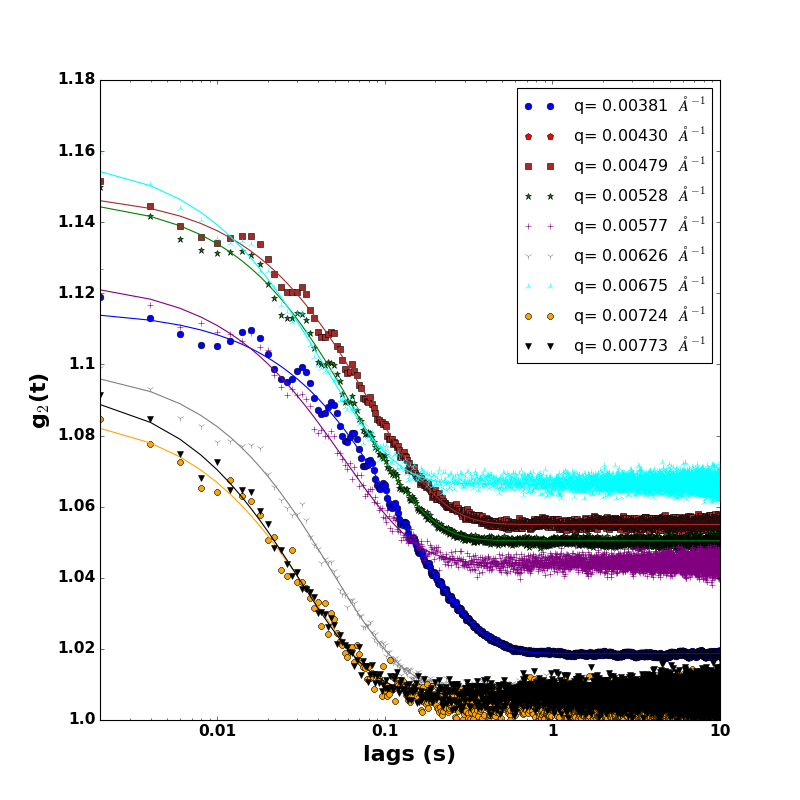

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [124]:
rate44 = []
fig, axes = plt.subplots(1, figsize=(10, 10))
roi_names = ["blue", "red", "brown", "green", "purple", "gray", "cyan", "orange", "black",
              "aqua"]

marks = ["o", "p", "s", "*","+", "1", "2","8", "v", "D",  "H"]
for i, roi_color, mark in zip(range(5,num_rings), roi_names, marks):
    y = g21[1:, i]
    result44 = mod.fit(y, lags=np.arange(g21.shape[0])[1:], beta=.1,
                     relaxation_rate =.01, baseline=1.0)
    rate44.append(result44.best_values['relaxation_rate'])
    axes.semilogx(taus2[1:], g21[1:, i], mark, markerfacecolor=roi_color, color=roi_color,
                  markersize=6, label=" q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes.semilogx(taus2[1:], result44.best_fit, '-', c=roi_color)
axes.set_ylim(bottom=1, top=1.18)
axes.set_ylabel("g$_{2}$(t)", **axis_font)
axes.set_xlabel("lags (s)", **axis_font)
axes.set_yticklabels([1.00, 1.02, 1.04, 1.06, 1.08, 1.10, 1.12, 1.14, 1.16, 1.18], **axis_font2)
axes.set_xticklabels([0, 10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2)], **axis_font2)
axes.set_xlim(0, 10**(1)) 
axes.legend(loc=1)
fig.savefig("g21.svg", bbox_inches='tight')
plt.show()